# Analysis of the t distribution evolving in the training

In [1]:
# python libraries
import glob
import numpy as np
import h5py
import math
import time
import datetime
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import model_from_json
import tensorflow as tf
from scipy.stats import norm, expon, chi2
from scipy.stats import chisquare
import os
import getpass

# open access to cernbox
os.system("echo %s| kinit" %getpass.getpass())

Using TensorFlow backend.


········


0

## Functions:

In [2]:
def Save_history_to_h5(DIR_OUT, file_name, extension, patience, tvalues_check):
    '''
    The function save the 2D-array of the loss histories in an .h5 file.
    
    DIR_OUT: directory where to save the output file
    file_name: output file name
    extension: label to be appended to the file_name
    
    No return.
    '''
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
        
    log_file = DIR_OUT+file_name+extension+'.h5' #'_tvalues_check.h5'
    print(log_file)
    f = h5py.File(log_file,"w")
    for i in range(tvalues_check.shape[1]):
        f.create_dataset(str(epochs_check[i]), data=tvalues_check[:, i], compression='gzip')
    f.close()
    print('Saved to file: ' +file_name+extension)
    return

def Read_history_from_h5(DIR_IN, file_name, extension, patience, epochs):
    '''
    The function creates a 2D-array from a .h5 file.
    
    DIR_OUT: directory where to save the input file
    file_name: input file name
    extension: label to be appended to the file_name
    
    The function returns a 2D-array with final shape (nr toys, nr check points). 
    '''
    
    tvalues_check = np.array([])
    epochs_check = []
    
    for i in range(epochs/patience):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
        
    log_file = DIR_IN+file_name+extension+'.h5'
    print(log_file)

    f = h5py.File(log_file,"r")
    for i in range(len(epochs_check)):
        # the t distribution at each check point is named by the epoch number
        t = f.get(str(epochs_check[i]))
        t = np.array(t)
        t = np.expand_dims(t, axis=1)
        #print(t.shape)
        if not i:
            # initialize the array at the first iteration
            tvalues_check = t
        else:
            # just append to tvalues_check
            tvalues_check = np.concatenate((tvalues_check, t), axis=1)
    f.close()
    print(tvalues_check.shape)
    return tvalues_check


def Read_t_from_h5(DIR_IN, file_name, extension):
    log_file = DIR_IN+file_name+extension+'.h5'
    print(log_file)
    tvalues_check = np.array([])
    f = h5py.File(log_file,"r")
    t = f.get('tvalues')
    t = np.array(t)
    print(t.shape)
    return t

def Extract_Tail(tvalues_check, patience, cut=95):
    tail_distribution = np.array([])
    normal_distribution = np.array([])
    epochs_check = []
    size = tvalues_check.shape[0]
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
        
    for i in range(tvalues_check.shape[1]):
        tvalues = np.sort(tvalues_check[:, i])
        percentile_cut = int(cut*0.01*size)
        #print(percentile_cut)
        bulk_distribution_i = tvalues[:percentile_cut]
        bulk_distribution_i = np.expand_dims(bulk_distribution_i, axis=1)
        tail_distribution_i = tvalues[percentile_cut:]
        tail_distribution_i = np.expand_dims(tail_distribution_i, axis=1)
        #print(tail_distribution_i.shape)
        if not i:
            tail_distribution = tail_distribution_i
            bulk_distribution = bulk_distribution_i
        else:
            tail_distribution = np.concatenate((tail_distribution, tail_distribution_i), axis=1)
            bulk_distribution = np.concatenate((bulk_distribution, bulk_distribution_i), axis=1)
    print('Tail distributions shape')
    print(tail_distribution.shape)
    print('Bulk distributions shape')
    print(bulk_distribution.shape)
    return tail_distribution, bulk_distribution

def Plot_Percentiles(tvalues_check, patience, title, ymax1=300, ymax2=0.01):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    
    patience: interval between two check points (epochs).
    tvalues_check: t=-2*loss
    '''
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    fig=plt.figure(figsize=(8, 8))
    quantiles=[2.5, 25, 50, 75, 97.5]
    percentiles=np.array([])
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('t', fontsize=12)
    plt.ylim(0, ymax1)
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        #print(percentiles_i.shape)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        #print(percentiles_i.shape)
        if not i:
            percentiles = percentiles_i.T
        else:
            percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend=[]
    print(percentiles.shape)
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.')
        legend.append(str(quantiles[j])+' % quantile')
    plt.legend(legend, fontsize=13)
    plt.grid()
    plt.show()
    fig.savefig(output_path+title+'_PlotPercentiles.png')
    plt.close(fig)
    return 

In [16]:
def Plot_CHI2_tests(output_path, titleID, tdistributions_check, patience, 
                    xmin, xmax, bins, dof, 
                    shift=0, plot_patience=50,
                    verbose=0, save=0):
    '''
    The function creates an array of plots for the distribution of t at different check points during the training.
    
    patience: interval between two check points (epochs).
    tdistributions_check: 2Darray of the t distribution history.
    '''
    epochs_check = []
    nr_check_points = tdistributions_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    # build the reference binned chi2 distribution starting from the cdf
    chi_range = xmax-xmin
    chi_bin = chi_range*1./bins
    chi_ref = np.array([])
    chi_xs = np.array([])
    
    for i in range(bins):
        chi_x = xmin+0.5*(chi_bin*(i)+chi_bin*(i+1))+shift
        chi_xs = np.append(chi_xs, chi_x)
        chi_integral = (chi2.cdf(xmin+chi_bin*(i+1), dof)-chi2.cdf(xmin+chi_bin*(i), dof))
        chi_ref= np.append(chi_ref, chi_integral)
        
    # setting the dimension of the plot grid    
    nplots = int(len(epochs_check)/plot_patience)+(len(epochs_check)%plot_patience > 0)
    ncols = 4
    nrows = int(nplots/4)+ (nplots% 4 > 0)
    fig_height = nrows*7
    fig_width = ncols*5
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # building histograms
    chi2_tests=[]
    p_val_chi2_tests=[]
    epoch_labels = []
    for check in range(len(epochs_check)):
        if check%plot_patience:
            continue
        plt.subplot(nrows, 4, check/plot_patience+1)
        epoch = epochs_check[check]
        epoch_labels.append(int(epoch/1000.))
        
        t = plt.hist(tdistributions_check[:, check], bins=bins, 
                     alpha=0.7, range=(xmin+shift, xmax+shift), edgecolor='blue')
        chi_ref_lineplot = plt.errorbar(chi_xs, chi_ref*np.sum(t[0]), yerr=np.sqrt(chi_ref*np.sum(t[0])), 
                                 color='darkgreen')
        plt.legend(['t distribution at '+str(epoch_labels[-1])+'k epochs', 'chi2 with '+str(dof)+' dof'],
                   loc='upper center', bbox_to_anchor=(0.5, -0.1)) 
        
        # building a chi2 test of compatibility between histogram and reference distribution
        chi2_obs = t[0]
        chi2_true = chi_ref*np.sum(t[0])
        
        numerator = np.multiply(np.subtract(chi2_obs, chi2_true), np.subtract(chi2_obs, chi2_true))
        denominator = chi2_true
        
        chi2_test = np.sum(np.divide(numerator, denominator))
        chi2_tests.append(chi2_test)
        
        p_val_chi2_test = 1.-chi2.cdf(chi2_test, bins-1)
        p_val_chi2_tests.append(p_val_chi2_test)
        props = dict(boxstyle='square', facecolor='white', alpha=0.1)
        ylmin, ylmax = plt.ylim()
        xlmin, xlmax = plt.xlim()
        textstr = "median: %f" %(np.median(tdistributions_check[:, check].astype(float)))
        
        plt.annotate(textstr, xy=(0.2, 0.9), xycoords='axes fraction',
                 #verticalalignment='top',horizontalalignment='right', 
                 fontsize=11)
    plt.subplots_adjust(left=0.25, bottom = 0.5, wspace=0.3, hspace=0.5)
    if verbose:
        plt.show()
    fig.savefig(output_path+titleID+'_hist_CHI2_dof'+str(dof)+'_'+str(xmin)+'-'+str(xmax)+'bins'+str(bins)+'.png')
    plt.close(fig)
    
    # plot compatibility test results
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_labels, chi2_tests)
    plt.plot([0, epoch_labels[-1]],[bins-1, bins-1])
    plt.plot([0, epoch_labels[-1]],[bins-1+np.sqrt(bins-1), bins-1+np.sqrt(bins-1)])
    plt.plot([0, epoch_labels[-1]],[bins-1+2*np.sqrt(bins-1), bins-1+2*np.sqrt(bins-1)])
    plt.plot([0, epoch_labels[-1]],[bins-1+3*np.sqrt(bins-1), bins-1+3*np.sqrt(bins-1)])
    plt.yscale('log')
    plt.xlabel('Epochs [k]')
    plt.ylabel('chi2 test')
    plt.grid()
    plt.legend(['chi2 obs','dof '+str(bins-1), 'dof + 1 sigma', 'dof + 2 sigma', 'dof + 3 sigma'])
    plt.subplot(1, 2, 2)
    plt.plot(epoch_labels, p_val_chi2_tests)
    plt.plot([0, epoch_labels[-1]],[0.05, 0.05])
    plt.plot([0, epoch_labels[-1]],[0.32, 0.32])
    plt.plot([0, epoch_labels[-1]],[0.5, 0.5])
    plt.legend(['p-values', '0.05', '0.32', '0.5'])
    plt.ylabel('p-value')
    plt.xlabel('Epochs [k]')
    #plt.yscale('log')
    
    #save into .h5
    log_file=output_path+'/'+titleID+'_CHI2_test.h5'
    f = h5py.File(log_file,"w")
    f.create_dataset(titleID.split('_')[-1], data=chi2_tests, compression='gzip')
    f.create_dataset('epochs', data=epoch_labels, compression='gzip')
    f.close()
    plt.grid()
    #plt.subplots_adjust(left=0.25, bottom = 0.3, wspace=0.3, hspace=0.3)
    if verbose:
        #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)
        plt.subplots_adjust(left=0.125, right=0.9, bottom = 0.25, wspace=0.3, hspace=0.2)
        plt.show()
    if save:
        fig.savefig(output_path+titleID+'_plot_CHI2_dof'+str(dof)+'_'+str(xmin)+'-'+str(xmax)+'bins'+str(bins)+'.png')
    plt.close(fig) 
    print(np.max(p_val_chi2_tests))
    return

In [4]:
def Plot_CHI2_comparison(output_path, titleID, 
                         tdistributions_check_b, tdistributions_check_sb, patience, 
                         xmin, xmax, bins, dof, 
                         plot_patience=50, verbose=0, save=0):
    '''
    The function creates the plots for the comparison of two samples of toys at different check points during the training.
    
    tdistributions_check_b: t distribution for the sample with BKG-only events.
    tdistributions_check_sb: t distribution for the sample with Sig+Bkg events.
    dof: number of degrees of freedom of the reference chi2 distribution.
    plot_patience: interval between two check points to be plotted (relative number of epochs = plot_patience*patience).
    '''
    
    epochs_check = []
    nr_check_points = tdistributions_check_b.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    chi2_tests=np.array([])
    p_val_chi2_tests50=np.array([])
    integral_chi2_tests50=np.array([])
    chisq = np.random.chisquare(dof, tdistributions_check_b.shape[0])
    chi_range=xmax-xmin
    chi_bin = chi_range*1./bins
    chi_ref=np.array([])
    chi_xs=np.array([])
    epochs=[]
    for i in range(bins):
        chi_x = xmin+0.5*(chi_bin*(i)+chi_bin*(i+1))
        chi_xs= np.append(chi_xs, chi_x)
        chi_integral = (chi2.cdf(xmin+chi_bin*(i+1), dof)-chi2.cdf(xmin+chi_bin*(i), dof))#*tdistributions_check_b.shape[0]
        chi_ref= np.append(chi_ref, chi_integral)
    
    
    # setting the dimension of the plot grid    
    nplots = int(len(epochs_check)/plot_patience)+(len(epochs_check)%plot_patience > 0)
    ncols = 4
    nrows = int(nplots/4)+ (nplots% 4 > 0)
    fig_height = nrows*5
    fig_width = ncols*10
    fig = plt.figure(figsize=(fig_width, fig_height))

    for check in range(len(epochs_check)):
        epoch = epochs_check[check]
        epochs.append(epoch/1000.)
        
        tvalues = tdistributions_check_sb[:, check]
        tvalues_BkgOnly = tdistributions_check_b[:, check]
        
        q50 = np.percentile(tvalues, 50.)
        counts50 = np.sum((tvalues_BkgOnly > q50).astype(int))
        p_val50 = counts50*1./len(tvalues_BkgOnly)
        integral50 = (chisq > q50).sum()*1./chisq.shape[0]
        p_val_chi2_tests50=np.append(p_val_chi2_tests50, p_val50)
        integral_chi2_tests50=np.append(integral_chi2_tests50, integral50)

        if check%plot_patience:
            continue
        plt.subplot(nrows, ncols, check/plot_patience+1)
        plt.hist(chi_xs, bins=bins, weights=chi_ref*tdistributions_check_b.shape[0], density = True, histtype = 'step', 
                 range=(xmin, xmax), linewidth=2, color='darkgreen')
        plt.hist(tdistributions_check_b[:, check], bins=bins, alpha = 0.7, density=True,
                   range=(xmin, xmax), edgecolor='blue')
        plt.hist(tdistributions_check_sb[:, check], bins=bins, alpha = 0.7, density=True,
                   range=(xmin, xmax), edgecolor='red')
        plt.title(str(epoch/1000)+'k epochs')
        #plt.legend([str(dof)+' dof true', 'Bkg only', 'Sig+Bkg'])
        props = dict(boxstyle='square', facecolor='white', alpha=0.1)
        ylmin, ylmax = plt.ylim()
        xlmin, xlmax = plt.xlim()
        textstr = "median Bkg only: %2f\nmedian Sig+Bkg %2f\np-value: %2f" %(round(np.median(tdistributions_check_b[:, check].astype(float)),2),
                                                                           round(np.median(tdistributions_check_sb[:, check].astype(float)), 2),
                                                                           round(p_val50, 2))
        plt.annotate(textstr, xy=(0.5, 0.7), xycoords='axes fraction',
                 #verticalalignment='top',horizontalalignment='right', 
                 fontsize=10)#, bbox=props)
        plt.subplots_adjust(left=0.25, right=0.8, bottom = 0.25, wspace=0.3, hspace=0.3)
    if verbose:
        plt.show()
    if save:
        fig.savefig(output_path+titleID+'_hist_SIGNIFICANCE_dof'+str(dof)+'_'+str(xmin)+'-'+str(xmax)+'bins'+str(bins)+'.png')
    plt.close(fig)
    
    #save data
    log_file=output_path+'/'+titleID+'_SIGNIFICANCE_test.h5'
    f = h5py.File(log_file,"w")
    f.create_dataset(titleID.split('_')[-1], data=p_val_chi2_tests50, compression='gzip')
    f.create_dataset('epochs', data=epochs, compression='gzip')
    f.close()
    
    #plot recap
    fig=plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, p_val_chi2_tests50, color='blue', linewidth=2, marker='.')
    plt.plot(epochs, integral_chi2_tests50, color='red', linewidth=1, marker='.')
    plt.legend(['observed 50%', 'th chi2 '+str(dof)+' dof 50%'])
    plt.ylabel('p-value')
    plt.xlabel('Epochs [k]')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, norm.ppf(1.-p_val_chi2_tests50), color='blue', linewidth=3, marker='.')
    plt.plot(epochs, norm.ppf(1.-integral_chi2_tests50), color='red', linewidth=3, marker='.')
    plt.legend(['observed 50%', 'th chi2 '+str(dof)+' dof 50%'])
    plt.ylabel('significance')
    plt.xlabel('Epochs [k]')
    plt.grid()
    if verbose:
        plt.show()
    if save:
        fig.savefig(output_path+titleID+'_plot_SIGNIFICANCE_dof'+str(dof)+'_'+str(xmin)+'-'+str(xmax)+'bins'+str(bins)+'.png')
    plt.close(fig)
    
    fig=plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.semilogy(epochs, p_val_chi2_tests50, color='blue', linewidth=2, marker='.')
    plt.semilogy(epochs, integral_chi2_tests50, color='red', linewidth=1, marker='.')
    plt.legend(['observed 50%', 'th chi2 '+str(dof)+' dof 50%'])
    plt.ylabel('p-value')
    plt.xlabel('Epochs [k]')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.semilogy(epochs, norm.ppf(1.-p_val_chi2_tests50), color='blue', linewidth=3, marker='.')
    plt.semilogy(epochs, norm.ppf(1.-integral_chi2_tests50), color='red', linewidth=2, marker='.')
    plt.legend(['observed 50%', 'th chi2 '+str(dof)+' dof 50%'])
    plt.ylabel('significance')
    plt.xlabel('Epochs [k]')
    plt.grid()
    if verbose:
        plt.show()
    if save:
        fig.savefig(output_path+titleID+'_plot_SIGNIFICANCE_dof'+str(dof)+'_'+str(xmin)+'-'+str(xmax)+'bins'+str(bins)+'_logscale.png')
    plt.close(fig) 
    return norm.ppf(1.-0.5*p_val_chi2_tests50)

In [5]:
def Plot_Analysis_tdistribution(output_path, title, tvalues_BkgOnly, tvalues, dof, rmin, rmax, bins=35, verbose=0, save=0):
    '''
    The function creates the plot for the comparison of two samples of toys at the end of the training.
    tvalues_BkgOnly: t distribution for the sample with BKG-only events.
    tvalues: t distribution for the sample with Sig+Bkg events.
    dof: number of degrees of freedom of the reference chi2 distribution.
    
    '''
    fig, ax = plt.subplots()
    chisq = np.random.chisquare(dof, 1000000)
    ax.hist(chisq, bins=bins, range=(rmin, rmax), density = True, histtype = 'step', linewidth=2, color='darkgreen')
    ax.hist(tvalues_BkgOnly, bins=bins, range=(rmin, rmax), density = True, alpha = 0.7, edgecolor='blue')
    ax.hist(tvalues, bins=bins, range=(rmin, rmax), density= True, alpha = 0.7, edgecolor='red')
    ax.legend(["$\chi^2$ with "+str(dof)+" dof",'Data samples following SM','Data samples containing New Physics'], loc='upper right')
    ax.set_ylabel('Probability')
    ax.set_xlabel("t")
    ax.set_title(title)
    #compute significance
    #median = np.median(tvalues)
    quantiles=np.percentile(tvalues, [16., 50., 84.])
    q50=quantiles[1]
    q16=quantiles[0]
    q84=quantiles[2]
    counts50 = np.sum((tvalues_BkgOnly > q50).astype(int))
    counts16 = np.sum((tvalues_BkgOnly > q16).astype(int))
    counts84 = np.sum((tvalues_BkgOnly > q84).astype(int))
    
    p_val50 = counts50*1./len(tvalues_BkgOnly)
    p_val16 = counts16*1./len(tvalues_BkgOnly)
    p_val84 = counts84*1./len(tvalues_BkgOnly)
    
    chisq = np.random.chisquare(dof, 100000000)
    integral50 = (chisq > q50).sum()/float(len(chisq))
    integral16 = (chisq > q16).sum()/float(len(chisq))
    integral84 = (chisq > q84).sum()/float(len(chisq))
    
    print("Bkg-only median: %f" %np.median(tvalues_BkgOnly))
    print("Bkg-only mean: %f" %np.mean(tvalues_BkgOnly))
    print("Bkg-only RMS: %f" %math.sqrt(np.var(tvalues_BkgOnly)))
    print("Sig+Bkg median: %f" %np.median(tvalues))
    print("Sig+Bkg mean: %f" %np.mean(tvalues))
    print("Sig+Bkg RMS: %f" %math.sqrt(np.var(tvalues)))
    
    print("p-value %f with 68 %% CL [%f, %f]" %(p_val50, p_val16, p_val84))
    print("number of sigmas: %f with 68%% CL [%f, %f]" %(norm.ppf(1.-p_val50), norm.ppf(1.-p_val16), norm.ppf(1.-p_val84)))
    print("p-value assuming %i dof chi square: %f" %(dof, integral50))
    print("number of sigmas assuming %i dof chi square: %f with 68 %% CL [%f, %f]" %(dof, norm.ppf(1.-integral50), norm.ppf(1.-integral16), norm.ppf(1.-integral84)))
    textstr = "Bkg-only median: %f\nSig+Bkg median: %f\nSignificance: %f $\sigma$\nTh Significance: %f $\sigma$" %(np.median(tvalues_BkgOnly), np.median(tvalues), norm.ppf(1.-p_val50), norm.ppf(1.-integral50))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='square', facecolor='white', alpha=0.1)

    # place a text box in upper left in axes coords
    ax.text(0.5, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    if verbose:
        plt.show()
    fig.savefig(output_path+title+'_t_distributions_dof'+str(dof)+'.png')
    plt.close(fig)
    return 

## Set parameters:

In [6]:
output_path='../BINNED/Zsamples/validation_CHI2/STOPPINGcriterion/'
#output_path='../BINNED/Zsamples/validation_CHI2/STOPPINGcriterion/300GeV/'
#output_path='../BINNED/1D_NP/STOPPINGcriterion/'
#output_path='../BINNED/1D_NP/09_10_18/'
#output_path='../BINNED/2D_MC/STOPPINGcriterion/'
#output_path='../BINNED/3D_MCC/STOPPINGcriterion/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

read_path='../BINNED/Zsamples/validation_CHI2/Scanning_outputs/300GeV/'
#read_path='../BINNED/1D_NP/Scanning_outputs/'
#read_path='../BINNED/2D_MC/Scanning_outputs/'
#read_path='../BINNED/3D_MCC/Scanning_outputs/'
#read_path='../BINNED/TESTS/Covariance_Checks/'
if not os.path.exists(read_path):
    os.makedirs(read_path)
    
DIR_INPUT_B='/eos/user/g/ggrosso/BINNED/Zsamples/300GeV/Z_5D_corrected_std_patience5000_ref1000000_bkg100000_sig0_epochs300000_latent5_layers3_wclip2/'
DIR_INPUT_SB='/eos/user/g/ggrosso/BINNED/Zsamples/300GeV/Z_5D_std_corrected_patience5000_ref1000000_bkg100000_sig40_epochs300000_latent5_layers3_wclip2/'

patience_B = DIR_INPUT_B.split("patience",1)[1] 
patience_B = patience_B.split("_",1)[0]
patience_SB = DIR_INPUT_SB.split("patience",1)[1] 
patience_SB = patience_SB.split("_",1)[0]

epochs_B = DIR_INPUT_B.split("epochs",1)[1] 
epochs_B = epochs_B.split("_",1)[0]
epochs_SB = DIR_INPUT_SB.split("epochs",1)[1] 
epochs_SB = epochs_SB.split("_",1)[0]

## Load data

In [7]:
if not DIR_INPUT_B.endswith('/'):
    DIR_INPUT_B = DIR_INPUT_B+'/'
    
title_B = DIR_INPUT_B.split('/')[-2]
tvalues_check_B = Read_history_from_h5(read_path, title_B, '_tvalues_check', int(patience_B), int(epochs_B))

../BINNED/Zsamples/validation_CHI2/Scanning_outputs/300GeV/Z_5D_corrected_std_patience5000_ref1000000_bkg100000_sig0_epochs300000_latent5_layers3_wclip2_tvalues_check.h5
(174, 60)


In [8]:
if not DIR_INPUT_B.endswith('/'):
    DIR_INPUT_B = DIR_INPUT_B+'/'

title_SB = DIR_INPUT_SB.split('/')[-2]
tvalues_check_SB=Read_history_from_h5(read_path, title_SB, '_tvalues_check', int(patience_SB), int(epochs_SB))

../BINNED/Zsamples/validation_CHI2/Scanning_outputs/300GeV/Z_5D_std_corrected_patience5000_ref1000000_bkg100000_sig40_epochs300000_latent5_layers3_wclip2_tvalues_check.h5
(148, 60)


(60, 5)


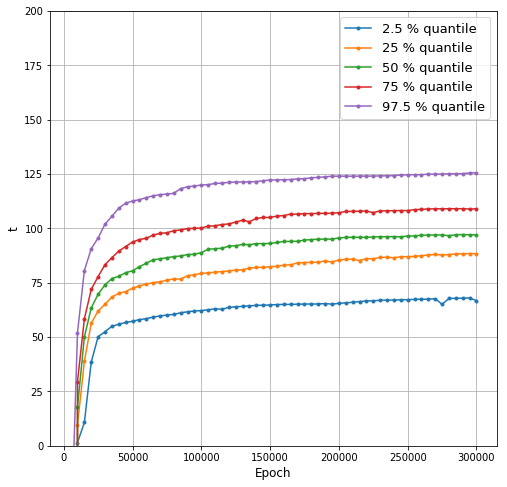

In [9]:
Plot_Percentiles(tvalues_check_B, int(patience_B), title_B, ymax1=200, ymax2=0.01)

## Analysis of the right end tail

In [10]:
tail_distribution, normal_distribution=Extract_Tail(tvalues_check_B, patience_B, cut=95)

Tail distributions shape
(9, 60)
Bulk distributions shape
(165, 60)


/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


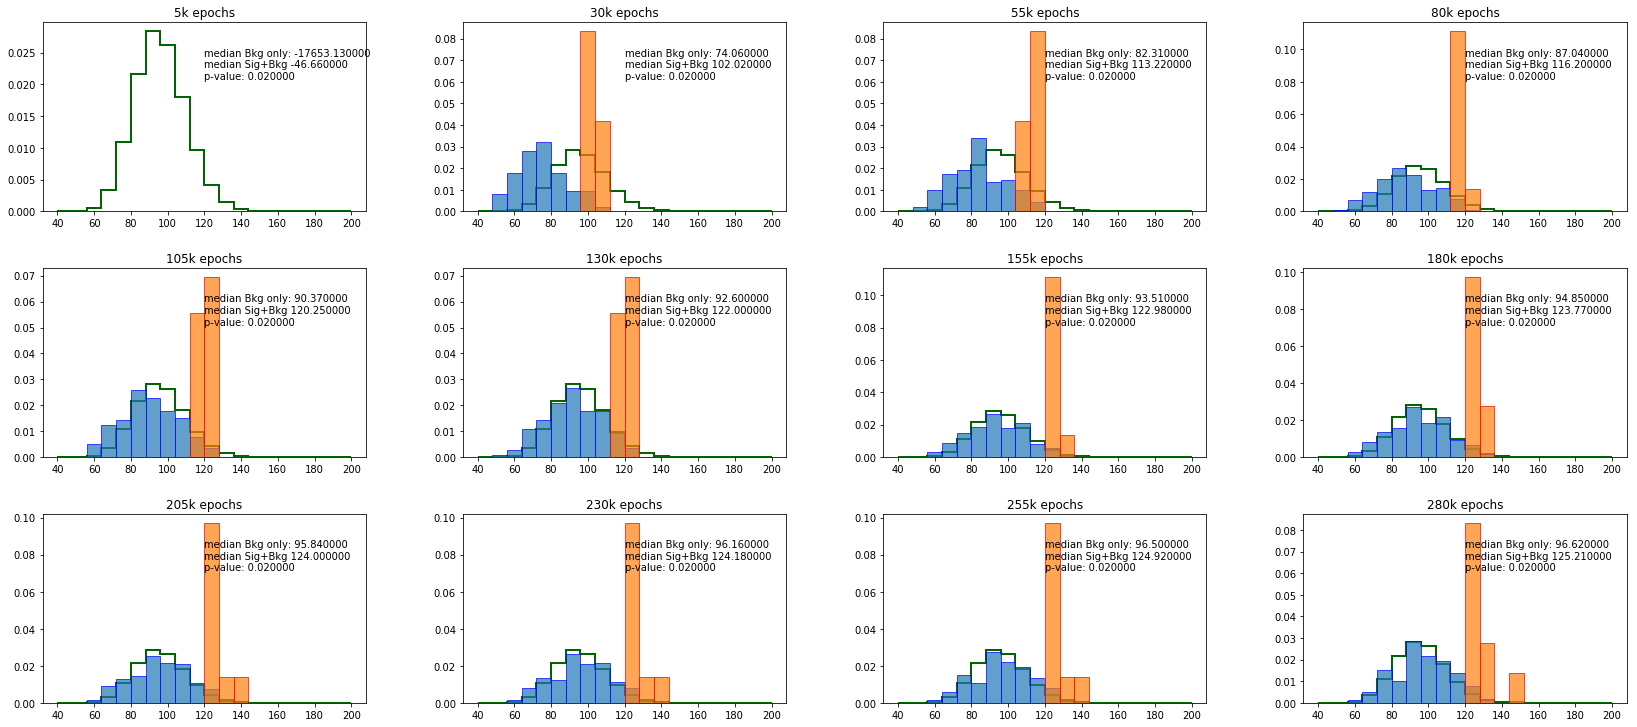

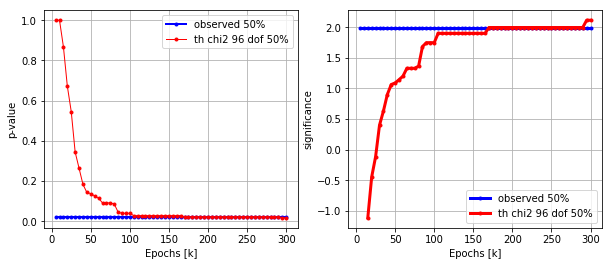

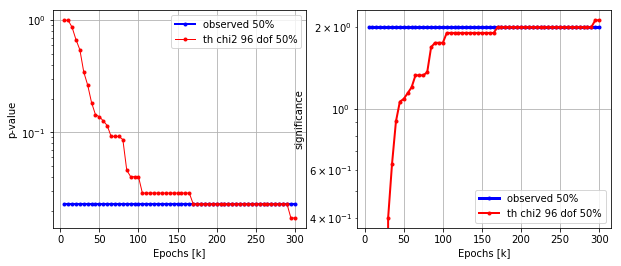

In [11]:
sig50 = Plot_CHI2_comparison(output_path, title_B, tvalues_check_B, tail_distribution, int(patience_B),
                                         40, 200, 20, 96, verbose=1, save=1, plot_patience=5)

## Chi2 test of the bkg-only t distribution

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in divide


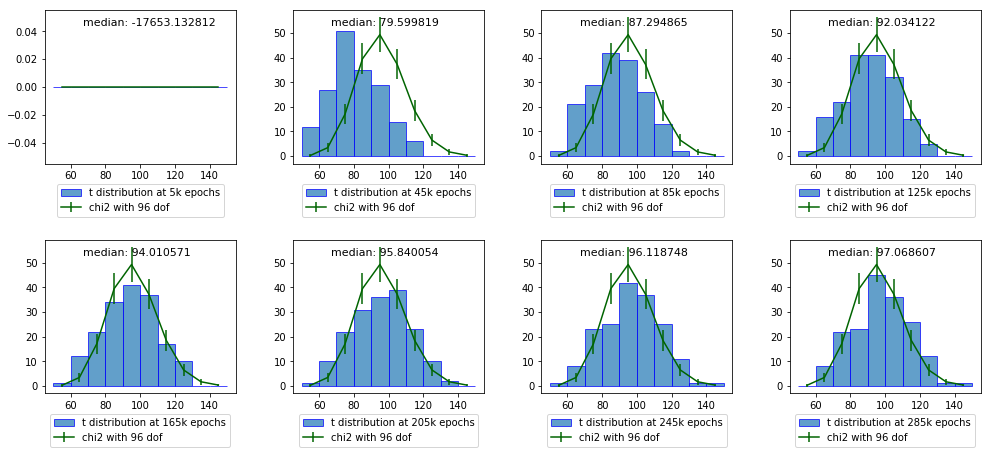

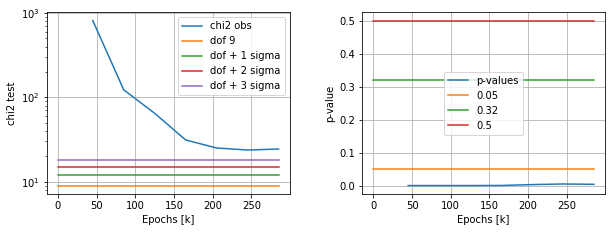

nan


In [15]:
Plot_CHI2_tests(output_path, title_B, tvalues_check_B, int(patience_B),
                50, 150, 10, 96, shift=0, plot_patience=8, 
                verbose=1, save=1)

## Validation 

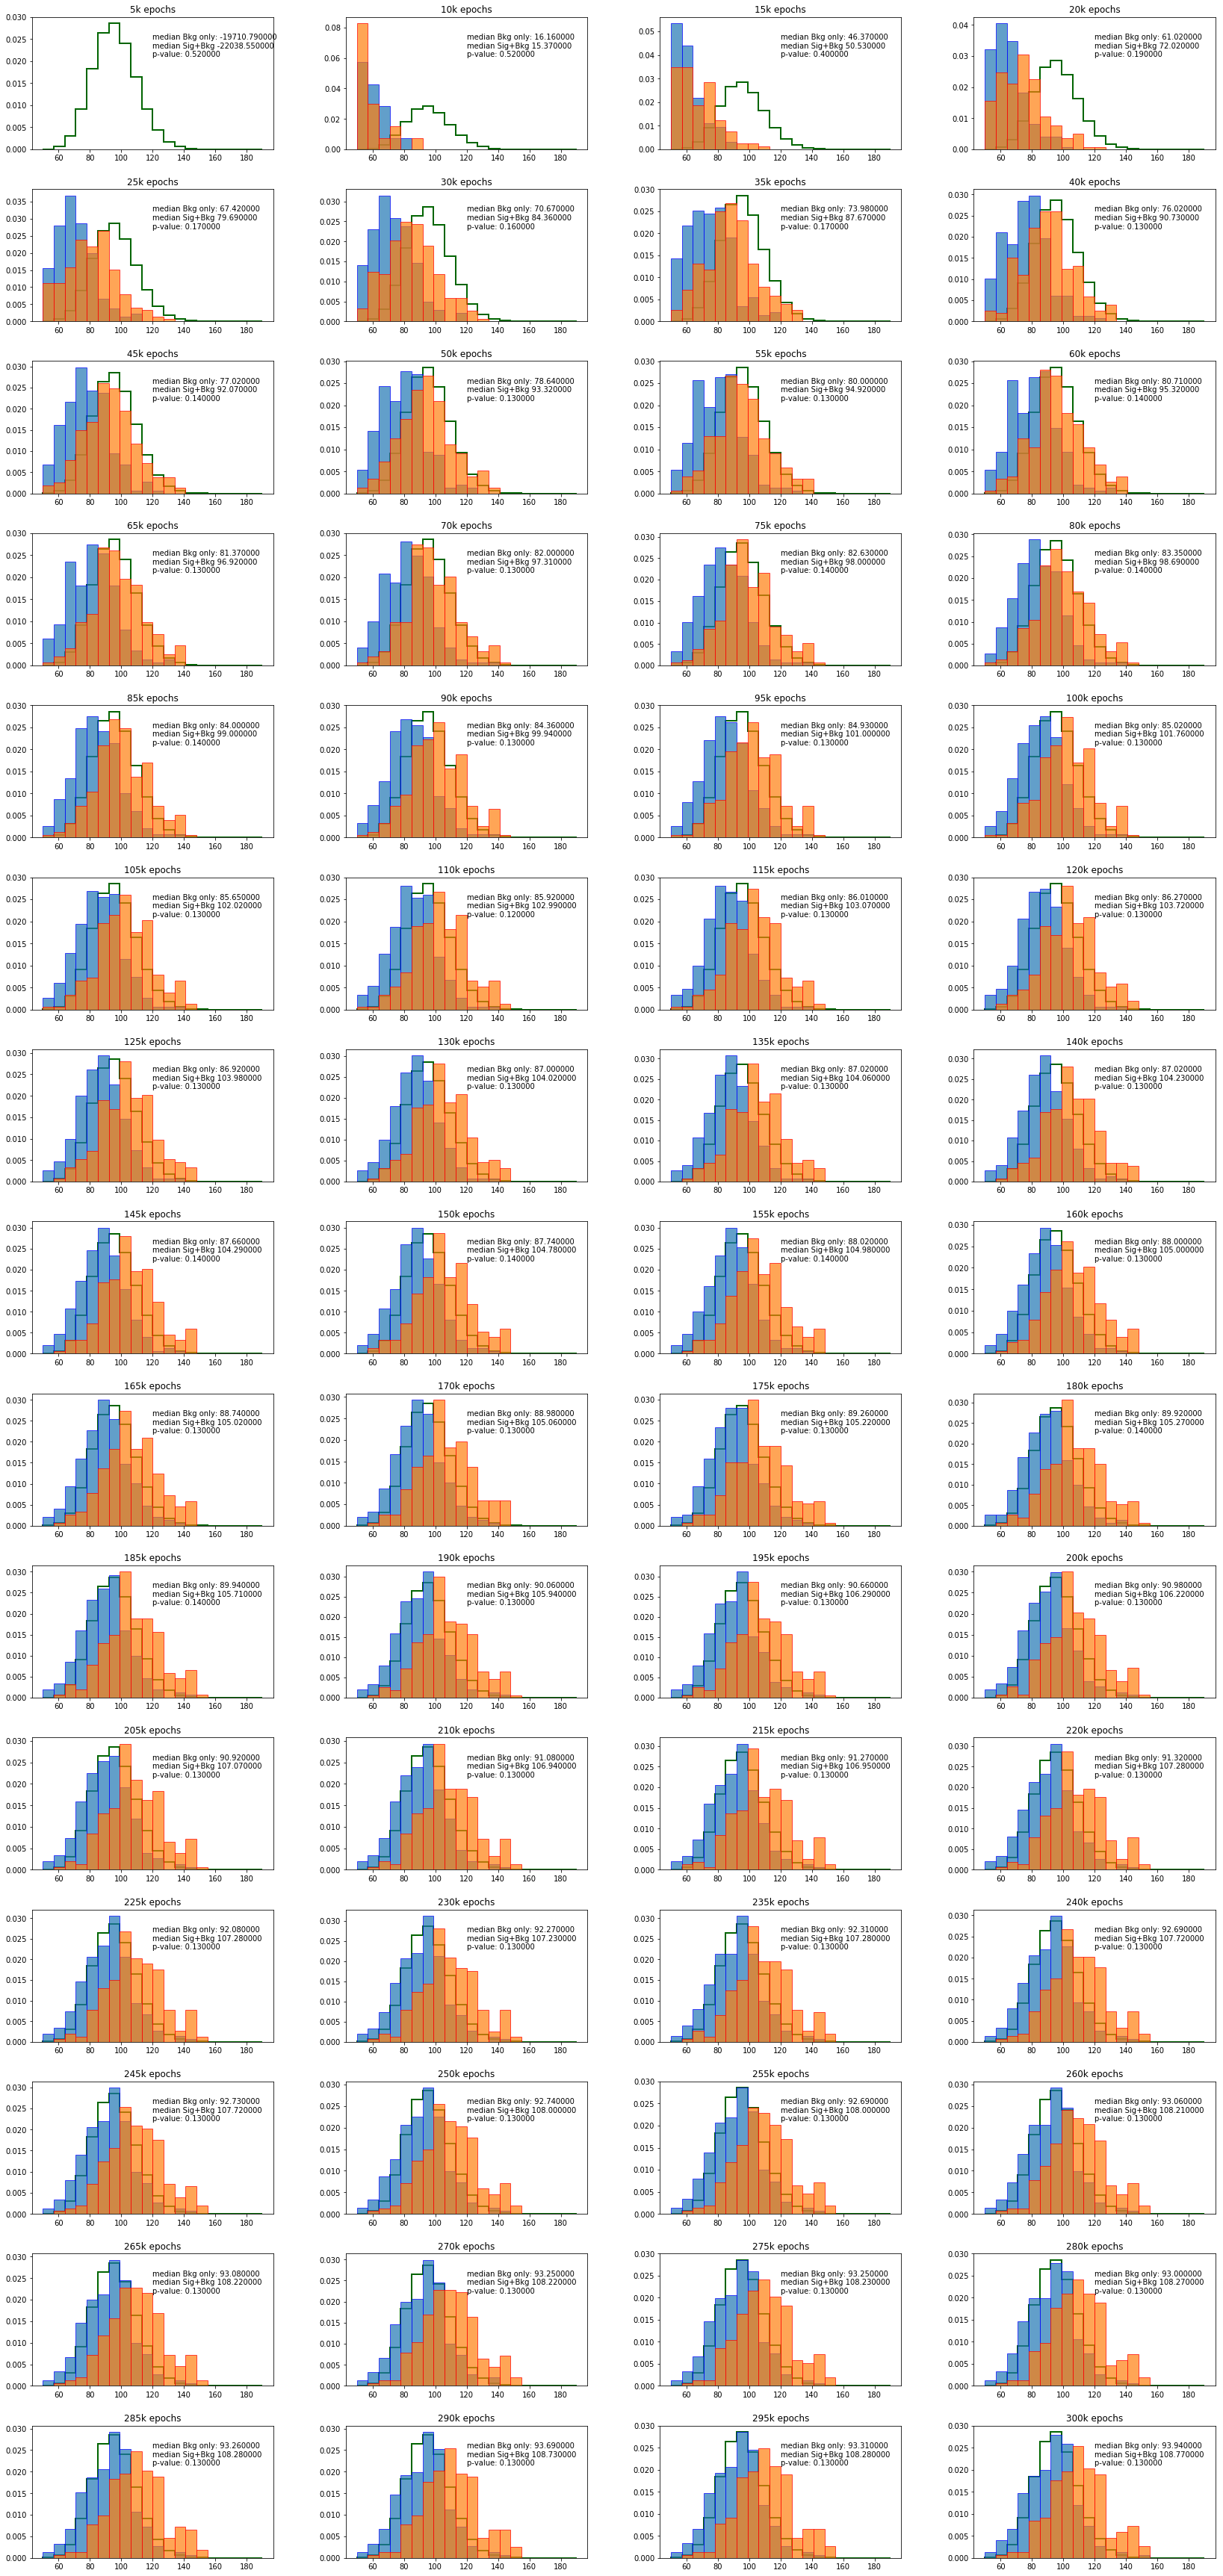

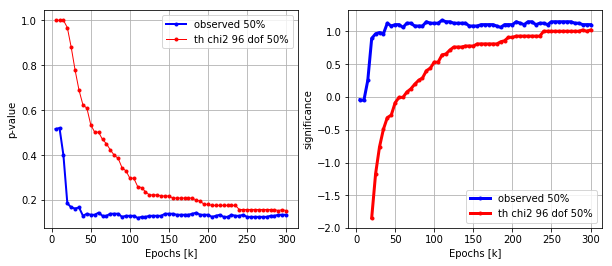

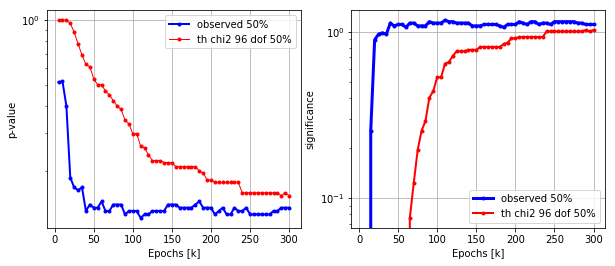

In [142]:
sig50 = Plot_CHI2_comparison(output_path, title_SB, tvalues_check_B, tvalues_check_SB, int(patience_B),
                                         50, 190, 20, 96, verbose=1, save=1, plot_patience=1)

### Performances at the end of the training 

In [143]:
# loading of the final t distributions
t_B = Read_t_from_h5(read_path, title_B, extension='_tvalues')
t_SB = Read_t_from_h5(read_path, title_SB, extension='_tvalues')

../BINNED/Zsamples/validation_CHI2/Scanning_outputs/300GeV/Z_5D_corrected_std_patience5000_ref1000000_bkg100000_sig0_epochs300000_latent5_layers3_wclip1.9_tvalues.h5
(215,)
../BINNED/Zsamples/validation_CHI2/Scanning_outputs/300GeV/Z_5D_std_corrected_patience5000_ref1000000_bkg100000_sig40_epochs300000_latent5_layers3_wclip1.9_tvalues.h5
(219,)


Bkg-only median: 93.322418
Bkg-only mean: 92.902360
Bkg-only RMS: 15.333863
Sig+Bkg median: 109.001076
Sig+Bkg mean: 110.321964
Sig+Bkg RMS: 17.608289
p-value 0.139535 with 68 % CL [0.520930, 0.013953]
number of sigmas: 1.082411 with 68% CL [-0.052488, 2.198592]
p-value assuming 96 dof chi square: 0.172009
number of sigmas assuming 96 dof chi square: 0.946256 with 68 % CL [-0.176503, 2.007870]


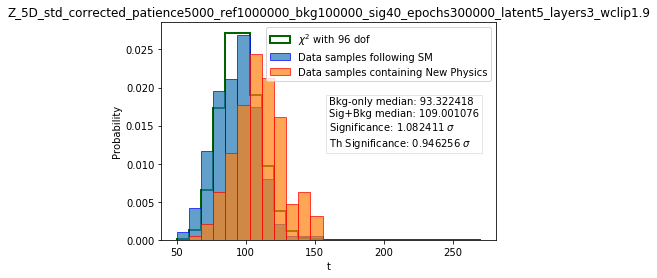

In [144]:
Plot_Analysis_tdistribution(output_path, title_SB, t_B, t_SB, dof=96, rmin=50, rmax=270, bins=25, verbose=1, save=1)